In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def load_dataset(path):
	
	data = pd.read_csv(path, header=3)
	timestamp = data.iloc[:, 0].to_numpy()
	output_voltage = data.iloc[:, 1].to_numpy()
	output_current = data.iloc[:, 2].to_numpy()
	thermistor_temperatures = data.iloc[:, 3:].to_numpy()

	comments = re.search(r"Comments: (.*)$", open(path).read(), re.MULTILINE)[1]

	return timestamp, output_voltage, output_current, thermistor_temperatures, comments

timestamp, output_voltage, output_current, thermistor_temperatures, comments = (
	load_dataset("../data/brass data/brass 10s.csv")
)

In [3]:
thermistor_num = [
    'thermistor_0/C',
    'thermistor_1/C',
    'thermistor_2/C',
    'thermistor_3/C',
    'thermistor_4/C',
    'thermistor_5/C',
    'thermistor_6/C',
    'thermistor_7/C'
]


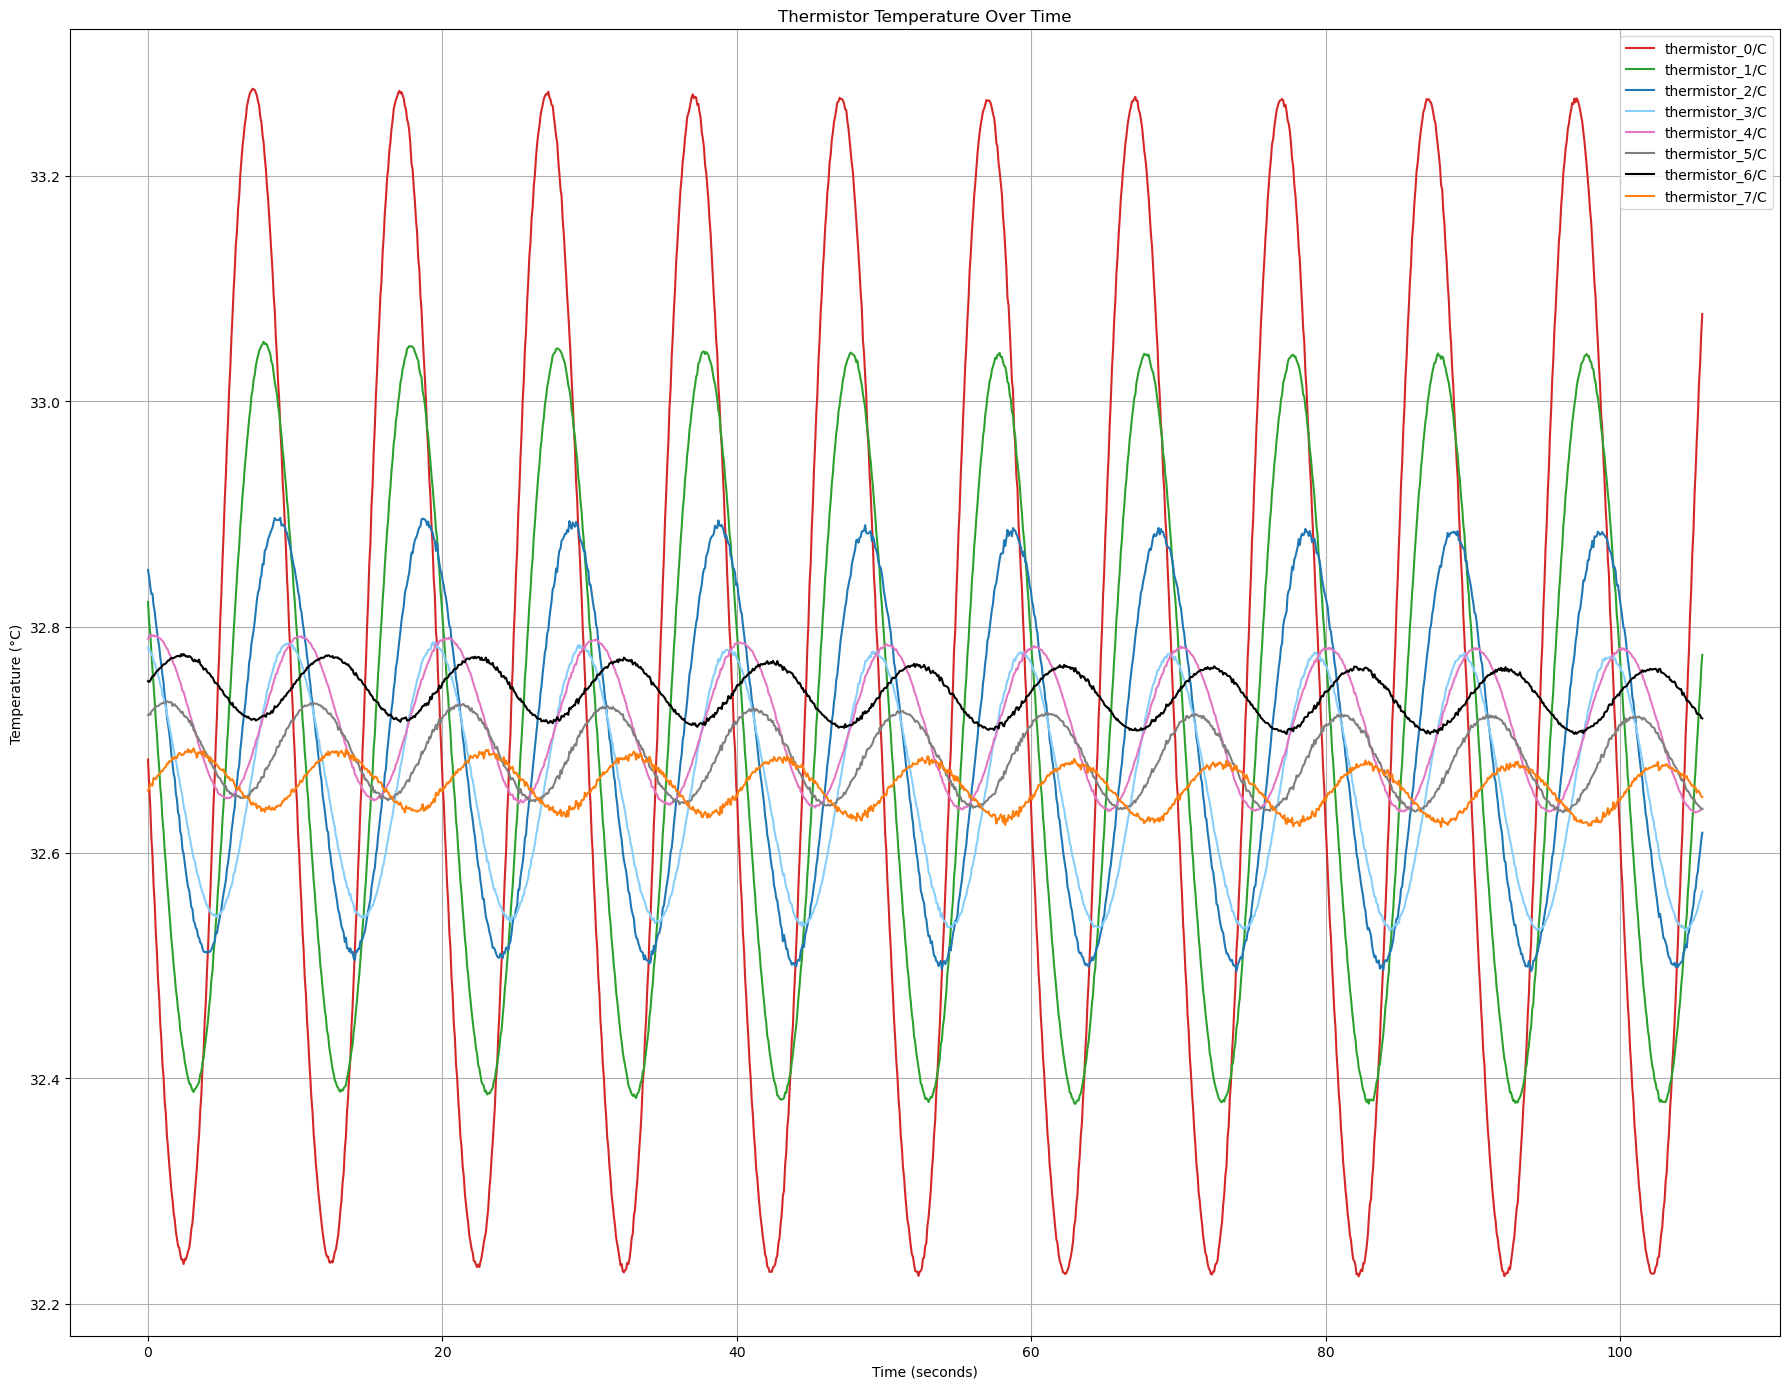

In [4]:
colors = ['tab:red', 'tab:green', 'tab:blue', 'lightskyblue', 
          'tab:pink', 'tab:gray', 'black', 'tab:orange']

plt.figure(figsize=(18, 14))

# Plot each thermistor's data with a different color and label
for i in range(8):
    plt.plot(timestamp, thermistor_temperatures[:,i], label=thermistor_num[i], color=colors[i])

plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.title('Thermistor Temperature Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
omega_guesses = [2 * np.pi / 10] * 8


Column 0 fit results:
  A     = 0.5214 ± 0.0006
  omega = 0.629552 ± 0.000037 rad/s
  phi   = -3.0036 ± 0.0023 rad
  B     = -0.000121 ± 0.000014 (slope)
  C     = 32.7533 ± 0.0008 (offset)
  Period = 9.9804 ± 0.0006 s


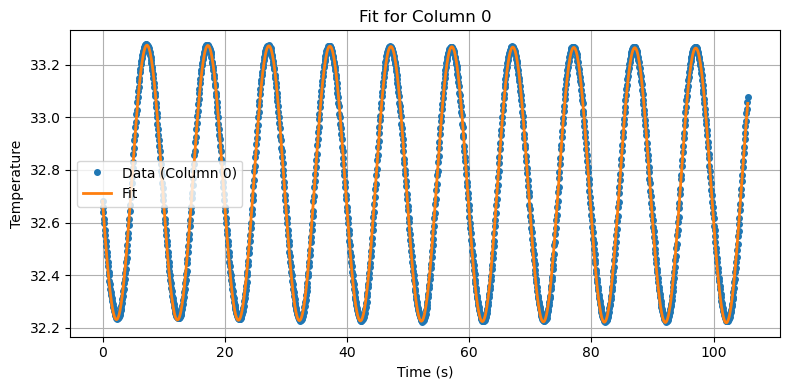


Column 1 fit results:
  A     = 0.3309 ± 0.0003
  omega = 0.629528 ± 0.000031 rad/s
  phi   = 2.8206 ± 0.0019 rad
  B     = -0.000128 ± 0.000007 (slope)
  C     = 32.7210 ± 0.0004 (offset)
  Period = 9.9808 ± 0.0005 s


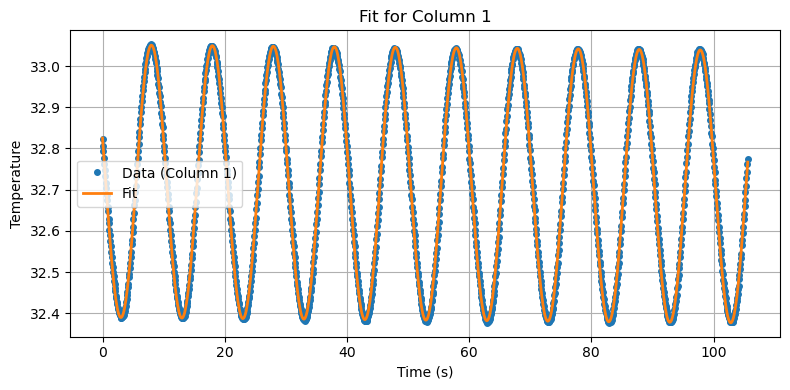


Column 2 fit results:
  A     = 0.1919 ± 0.0002
  omega = 0.629506 ± 0.000028 rad/s
  phi   = 2.2464 ± 0.0017 rad
  B     = -0.000129 ± 0.000004 (slope)
  C     = 32.7045 ± 0.0002 (offset)
  Period = 9.9811 ± 0.0004 s


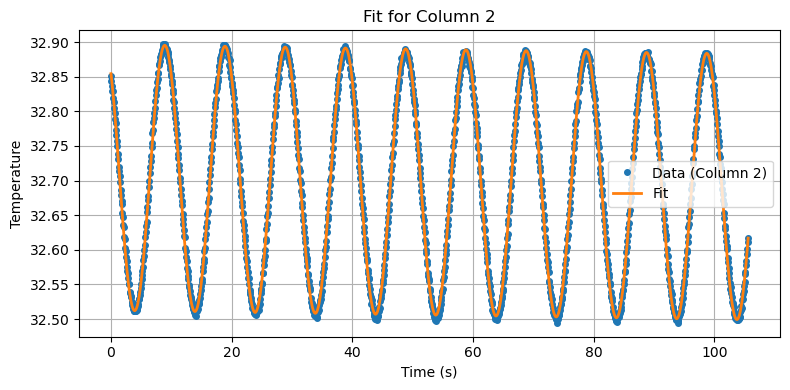


Column 3 fit results:
  A     = 0.1208 ± 0.0001
  omega = 0.629516 ± 0.000026 rad/s
  phi   = 1.8388 ± 0.0015 rad
  B     = -0.000133 ± 0.000002 (slope)
  C     = 32.6663 ± 0.0001 (offset)
  Period = 9.9810 ± 0.0004 s


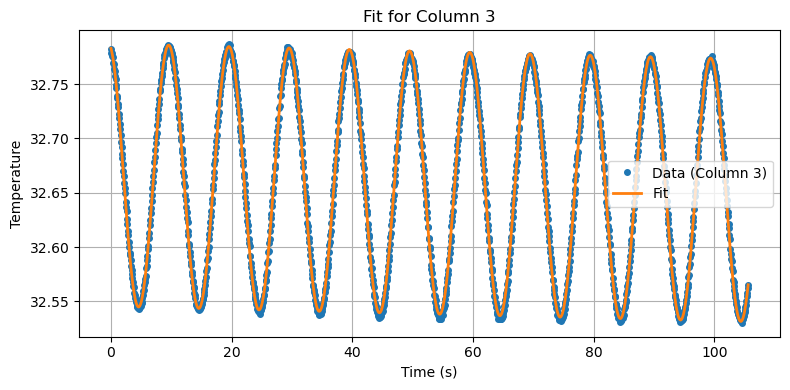


Column 4 fit results:
  A     = 0.0719 ± 0.0001
  omega = 0.629475 ± 0.000024 rad/s
  phi   = 1.3383 ± 0.0015 rad
  B     = -0.000135 ± 0.000001 (slope)
  C     = 32.7208 ± 0.0001 (offset)
  Period = 9.9816 ± 0.0004 s


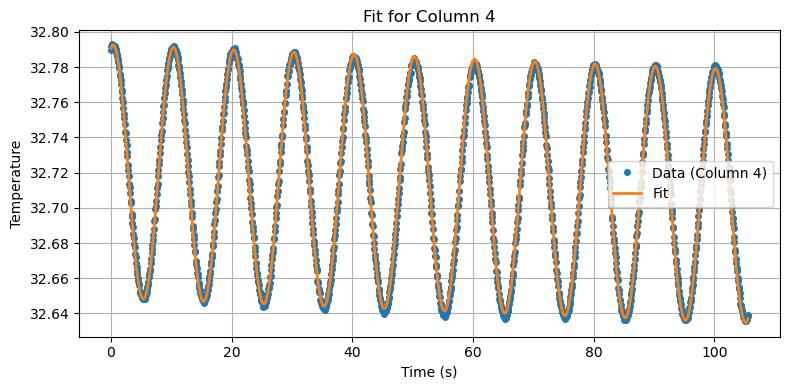


Column 5 fit results:
  A     = 0.0418 ± 0.0001
  omega = 0.629465 ± 0.000047 rad/s
  phi   = 0.7656 ± 0.0029 rad
  B     = -0.000139 ± 0.000001 (slope)
  C     = 32.6918 ± 0.0001 (offset)
  Period = 9.9818 ± 0.0007 s


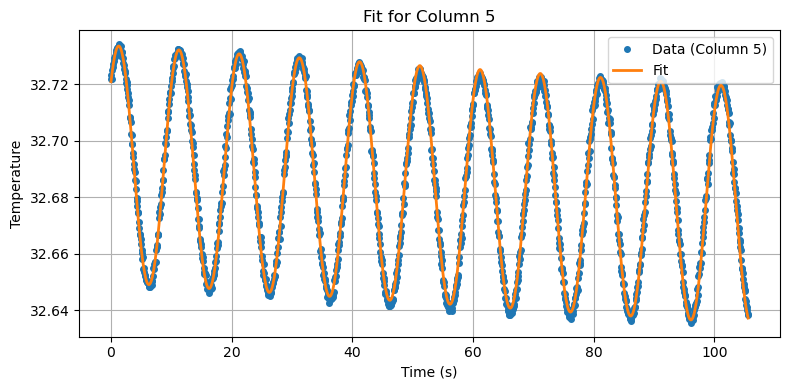


Column 6 fit results:
  A     = 0.0280 ± 0.0001
  omega = 0.629428 ± 0.000060 rad/s
  phi   = 0.1198 ± 0.0037 rad
  B     = -0.000141 ± 0.000001 (slope)
  C     = 32.7473 ± 0.0001 (offset)
  Period = 9.9824 ± 0.0010 s


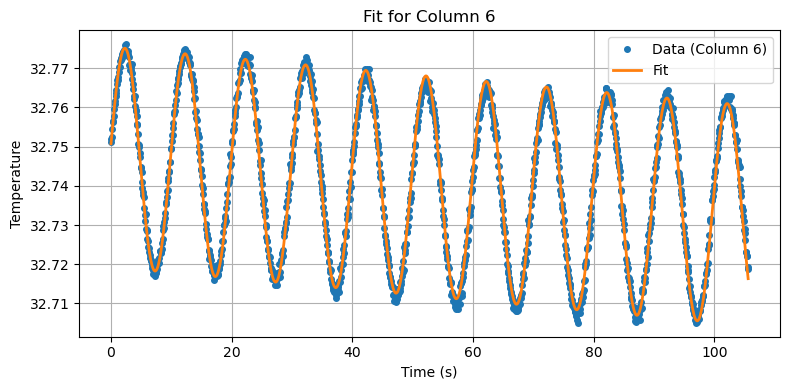


Column 7 fit results:
  A     = 0.0256 ± 0.0001
  omega = 0.629418 ± 0.000097 rad/s
  phi   = -0.3441 ± 0.0059 rad
  B     = -0.000143 ± 0.000002 (slope)
  C     = 32.6654 ± 0.0001 (offset)
  Period = 9.9825 ± 0.0015 s


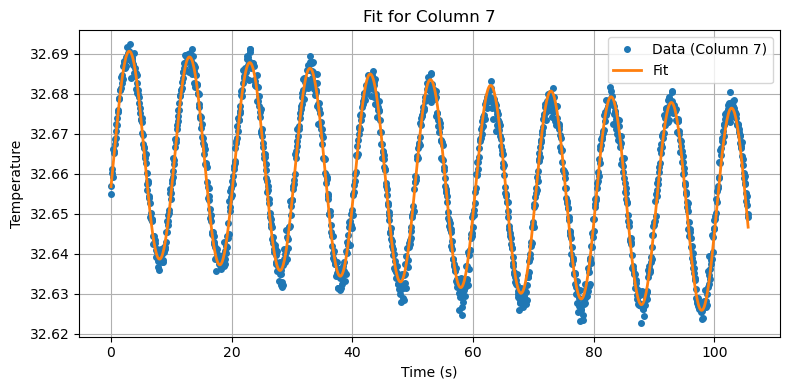

In [6]:
def sin_plus_line(t, A, omega, phi, B, C):
    return A * np.sin(omega * t + phi) + B * t + C

def initial_guess(t, y, omega_guess):
    A_guess = (np.max(y) - np.min(y)) / 2
    phi_guess = 0
    B_guess = 0  # Assuming no trend as initial guess
    C_guess = np.mean(y)
    return [A_guess, omega_guess, phi_guess, B_guess, C_guess]

n_columns = thermistor_temperatures.shape[1]
assert len(omega_guesses) == n_columns, "Length of omega_guesses must match number of columns"

fit_results = []  
for i in range(n_columns):
    y = thermistor_temperatures[:, i]
    omega_0 = omega_guesses[i]
    
    try:
        popt, pcov = curve_fit(
            sin_plus_line,
            timestamp,
            y,
            p0=initial_guess(timestamp, y, omega_0)
        )

        A, omega, phi, B, C = popt
        A, omega, phi, B, C = popt


        if A < 0:
          A = -A
          phi = phi + np.pi
          phi = (phi + np.pi) % (2*np.pi) - np.pi  

        perr = np.sqrt(np.diag(pcov))
        A_err, omega_err, phi_err, B_err, C_err = perr

        period = 2 * np.pi / omega if omega != 0 else np.nan
        period_err = (2 * np.pi / omega**2) * omega_err if omega != 0 else np.nan

        fit_results.append({
            'column': i,
            'A': (A, A_err),
            'omega': (omega, omega_err),
            'phi': (phi, phi_err),
            'B': (B, B_err),
            'C': (C, C_err),
            'period': (period, period_err)
        })

        print(f"\nColumn {i} fit results:")
        print(f"  A     = {A:.4f} ± {A_err:.4f}")
        print(f"  omega = {omega:.6f} ± {omega_err:.6f} rad/s")
        print(f"  phi   = {phi:.4f} ± {phi_err:.4f} rad")
        print(f"  B     = {B:.6f} ± {B_err:.6f} (slope)")
        print(f"  C     = {C:.4f} ± {C_err:.4f} (offset)")
        print(f"  Period = {period:.4f} ± {period_err:.4f} s")
        
        t_fit = np.linspace(min(timestamp), max(timestamp), 1000)
        y_fit = sin_plus_line(t_fit, *popt)

        plt.figure(figsize=(8, 4))
        plt.plot(timestamp, y, 'o', label=f'Data (Column {i})', markersize=4)
        plt.plot(t_fit, y_fit, '-', label='Fit', linewidth=2)
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature')
        plt.title(f'Fit for Column {i}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except RuntimeError as e:
        print(f"Fit failed for column {i}: {e}")
        fit_results.append({
            'column': i,
            'error': str(e)
        })

In [7]:
def error_percentages (i):
        y = thermistor_temperatures[:, i]
        omega_0 = omega_guesses[i]

        popt, pcov = curve_fit(
            sin_plus_line,
            timestamp,
            y,
            p0=initial_guess(timestamp, y, omega_0)
        )

        A, omega, phi, B, C = popt
        perr = np.sqrt(np.diag(pcov))
        A_err, omega_err, phi_err, B_err, C_err = perr
        return (perr/popt)

In [8]:
def sin_fit_val(i):
    
    y = thermistor_temperatures[:, i]
    omega_0 = omega_guesses[i]

    popt, pcov = curve_fit(
        sin_plus_line,
        timestamp,
        y,
        p0=initial_guess(timestamp, y, omega_0)
    )

    A, omega, phi, B, C = popt

    if A < 0:
        A = -A
        phi = phi + np.pi

        phi = (phi + np.pi) % (2 * np.pi) - np.pi

    return np.array([A, omega, phi, B, C])

In [9]:
for res in fit_results:
    if 'error' in res:
        print(f"\nColumn {res['column']}: Fit failed ({res['error']})")
    else:
        print(f"\nColumn {res['column']} fit results:")
        print(f"  A     = {res['A'][0]:.4f} ± {res['A'][1]:.4f}")
        print(f"  omega = {res['omega'][0]:.6f} ± {res['omega'][1]:.6f} rad/s")
        print(f"  phi   = {res['phi'][0]:.4f} ± {res['phi'][1]:.4f} rad")
        print(f"  B     = {res['B'][0]:.6f} ± {res['B'][1]:.6f} (slope)")
        print(f"  C     = {res['C'][0]:.4f} ± {res['C'][1]:.4f} (offset)")
        print(f"  Period = {res['period'][0]:.4f} ± {res['period'][1]:.4f} s")


Column 0 fit results:
  A     = 0.5214 ± 0.0006
  omega = 0.629552 ± 0.000037 rad/s
  phi   = -3.0036 ± 0.0023 rad
  B     = -0.000121 ± 0.000014 (slope)
  C     = 32.7533 ± 0.0008 (offset)
  Period = 9.9804 ± 0.0006 s

Column 1 fit results:
  A     = 0.3309 ± 0.0003
  omega = 0.629528 ± 0.000031 rad/s
  phi   = 2.8206 ± 0.0019 rad
  B     = -0.000128 ± 0.000007 (slope)
  C     = 32.7210 ± 0.0004 (offset)
  Period = 9.9808 ± 0.0005 s

Column 2 fit results:
  A     = 0.1919 ± 0.0002
  omega = 0.629506 ± 0.000028 rad/s
  phi   = 2.2464 ± 0.0017 rad
  B     = -0.000129 ± 0.000004 (slope)
  C     = 32.7045 ± 0.0002 (offset)
  Period = 9.9811 ± 0.0004 s

Column 3 fit results:
  A     = 0.1208 ± 0.0001
  omega = 0.629516 ± 0.000026 rad/s
  phi   = 1.8388 ± 0.0015 rad
  B     = -0.000133 ± 0.000002 (slope)
  C     = 32.6663 ± 0.0001 (offset)
  Period = 9.9810 ± 0.0004 s

Column 4 fit results:
  A     = 0.0719 ± 0.0001
  omega = 0.629475 ± 0.000024 rad/s
  phi   = 1.3383 ± 0.0015 rad
  B     

In [10]:
def error_from_two (a, b, quantity):
    a_errors_percentages = error_percentages(a)
    b_errors_percentages = error_percentages(b)
    result = np.sqrt((a_errors_percentages[quantity])**2 + (b_errors_percentages[quantity])**2)
    return result

In [11]:
def DA_DPhi(a, b):
    
    A_a, omega_a, phi_a, _, _ = sin_fit_val(a)
    A_b, omega_b, phi_b, _, _ = sin_fit_val(b)

    omega = np.mean([omega_a, omega_b])
    delta_d = 0.005 * np.abs(a - b)

    A_ratio = np.abs(A_b) / np.abs(A_a)
    delta_phi = np.abs(phi_b - phi_a)

    DA = omega * (delta_d)**2 / (2 * (np.log(A_ratio))**2)
    Dphi = omega * (delta_d)**2 / (2 * (delta_phi)**2)

    error_in_A_ratio = error_from_two(a, b, 0)      
    error_in_delta_phi = error_from_two(a, b, 2)    

    r_A = error_in_A_ratio / 100
    r_phi = error_in_delta_phi / 100

    DA_rel_error = 2 * r_A / np.abs(np.log(A_ratio))
    Dphi_rel_error = 2 * r_phi / np.abs(delta_phi)

    DA_error = DA * DA_rel_error
    Dphi_error = Dphi * Dphi_rel_error

    DA_error_percent = DA_rel_error * 100
    Dphi_error_percent = Dphi_rel_error * 100

    return {
        "DA": DA,
        "DA_error": DA_error,
        "DA_error_%": DA_error_percent,
        "Dphi": Dphi,
        "Dphi_error": Dphi_error,
        "Dphi_error_%": Dphi_error_percent
    }


In [12]:
DA_DPhi(0, 3)

{'DA': 3.312232014702423e-05,
 'DA_error': 6.294237282691957e-10,
 'DA_error_%': 0.0019003008408689155,
 'Dphi': 3.020285817139391e-06,
 'Dphi_error': 2.082792701243974e-10,
 'Dphi_error_%': 0.006896011925178172}

In [13]:
for i in range (7):
    print(f"D from {i+1} : {DA_DPhi(0, i+1)}")

D from 1 : {'DA': 3.805702829244516e-05, 'DA_error': 2.5084317574297643e-09, 'DA_error_%': 0.006591244429685862, 'Dphi': 2.319858659925006e-07, 'Dphi_error': 1.4078380325614727e-11, 'Dphi_error_%': 0.006068637097947096}
D from 2 : {'DA': 3.151660506378138e-05, 'DA_error': 9.049570344320793e-10, 'DA_error_%': 0.002871365848576274, 'Dphi': 1.1420067301910484e-06, 'Dphi_error': 7.300619208884205e-11, 'Dphi_error_%': 0.00639279876018145}
D from 3 : {'DA': 3.312232014702423e-05, 'DA_error': 6.294237282691957e-10, 'DA_error_%': 0.0019003008408689155, 'Dphi': 3.020285817139391e-06, 'Dphi_error': 2.082792701243974e-10, 'Dphi_error_%': 0.006896011925178172}
D from 4 : {'DA': 3.2081631238549136e-05, 'DA_error': 4.4051793653248133e-10, 'DA_error_%': 0.0013731157660186464, 'Dphi': 6.678393134070479e-06, 'Dphi_error': 5.140774530159704e-10, 'Dphi_error_%': 0.007697621908380232}
D from 5 : {'DA': 3.0918595136416945e-05, 'DA_error': 4.4936443769966714e-10, 'DA_error_%': 0.001453379222817245, 'Dphi': 

D from 1: {'DA': 3.805702829244516e-05, 'DA_error': 2.5084317574297643e-09, 'DA_error_%': 0.006591244429685862, 'Dphi': 2.319858659925006e-07, 'Dphi_error': 1.4078380325614727e-11, 'Dphi_error_%': 0.006068637097947096}
D from 2: {'DA': 3.151660506378138e-05, 'DA_error': 9.049570344320793e-10, 'DA_error_%': 0.002871365848576274, 'Dphi': 1.1420067301910484e-06, 'Dphi_error': 7.300619208884205e-11, 'Dphi_error_%': 0.00639279876018145}
D from 3: {'DA': 3.312232014702423e-05, 'DA_error': 6.294237282691957e-10, 'DA_error_%': 0.0019003008408689155, 'Dphi': 3.020285817139391e-06, 'Dphi_error': 2.082792701243974e-10, 'Dphi_error_%': 0.006896011925178172}
D from 4: {'DA': 3.2081631238549136e-05, 'DA_error': 4.4051793653248133e-10, 'DA_error_%': 0.0013731157660186464, 'Dphi': 6.678393134070479e-06, 'Dphi_error': 5.140774530159704e-10, 'Dphi_error_%': 0.007697621908380232}
D from 5: {'DA': 3.0918595136416945e-05, 'DA_error': 4.4936443769966714e-10, 'DA_error_%': 0.001453379222817245, 'Dphi': 1.384

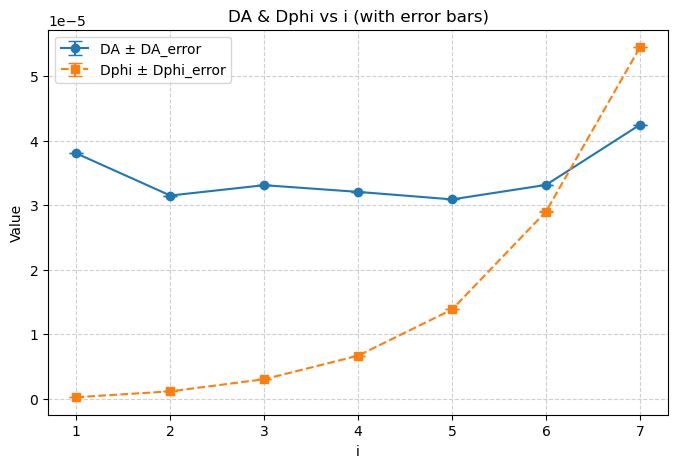

In [14]:
import matplotlib.pyplot as plt

# Lists to store data
i_values = []
DA_values = []
DA_err_values = []
Dphi_values = []
Dphi_err_values = []

# Loop through i = 1 to 7
for i in range(7):
    result = DA_DPhi(0, i + 1)
    print(f"D from {i + 1}: {result}")
    
    i_values.append(i + 1)
    DA_values.append(result["DA"])
    DA_err_values.append(result["DA_error"])
    Dphi_values.append(result["Dphi"])
    Dphi_err_values.append(result["Dphi_error"])

# --- Plotting both on the same axes ---
plt.figure(figsize=(8, 5))

plt.errorbar(i_values, DA_values, yerr=DA_err_values, fmt='o-', capsize=5, label='DA ± DA_error')
plt.errorbar(i_values, Dphi_values, yerr=Dphi_err_values, fmt='s--', capsize=5, label='Dphi ± Dphi_error')

plt.title("DA & Dphi vs i (with error bars)")
plt.xlabel("i")
plt.ylabel("Value")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()
